In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import swifter

from glob import glob
from itertools import product
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, ScalarFormatter
from tqdm.notebook import tqdm

sns.set_style(style='whitegrid')

In [4]:
models = ['Transformer', 'N-BEATS', 'GRU', 'LSTM']
tasks = ['none', 'featurization', 'classification', 'forecasting']

markers = dict(zip(tasks, [',', 'X', 'o', '>']))

In [5]:
def plot(
    ylabel: str,
    ylogscale: bool = False,
    rolling_window: int = 200,
    markevery=0.1,
    fig_name=None,
    fig_size=(8, 4),
    xticks_every=3,
    yticks_every=None,
    xticks_minor=None,
    markersize=10,
    linewidth=0.8,
    dashes=False,
    ylim=None,
    **kwargs
):
    fgrid = sns.lineplot(
        markevery=markevery,
        markersize=markersize,
        palette='colorblind',
        linewidth=linewidth,
        dashes=dashes,
        **kwargs
    )
    fgrid.figure.set_size_inches(fig_size)
    fgrid.xaxis.set_major_locator(MultipleLocator(xticks_every))
    if xticks_minor is None:
        xticks_minor = xticks_every
    fgrid.xaxis.set_minor_locator(AutoMinorLocator(xticks_minor))
    if yticks_every is not None:
        fgrid.yaxis.set_major_locator(MultipleLocator(yticks_every))
    
    fgrid.grid(which='major', color='#CCCCCC', linestyle='--')
    fgrid.grid(which='minor', color='#CCCCCC', linestyle=':')
    fgrid.set(ylabel=ylabel)
    if fig_name is not None:
        fgrid.get_figure().savefig(fig_name, format='pdf')
    if ylogscale:
        fgrid.set(yscale='log')
    if ylim is not None:
        fgrid.set(ylim=ylim)
    return fgrid

In [6]:
def plots_per_model(data: pd.DataFrame, 
                    x='epoch',
                    ylogscale: bool = False, 
                    legend_pos: int = 1, 
                    markers=markers, 
                    sharex=True,
                    sharey=True,
                    fig_size=(10, 7),
                    ncol=2,
                    **kwargs):
    fig, axes = plt.subplots(2, 2, sharex=sharex, sharey=sharey)
    for i, model in enumerate(models):
        curr_ax = axes[i // 2, i % 2]
        plot(
            data=data[data.model == model],
            x=x,
            markers=markers,
            legend=(i==legend_pos),
            ax=curr_ax,
            fig_size=fig_size,
            **kwargs
        )
        if ylogscale and not sharey:
            curr_ax.set_yscale('log')
        curr_ax.title.set_text(model)
    
    legend_ax = axes[legend_pos // 2, legend_pos % 2]
    if ncol != 1:
        handles, labels = legend_ax.get_legend_handles_labels()
        legend_ax.legend(handles=handles, labels=labels, ncol=ncol)
    fig.set_tight_layout(True)
    if sharex:
        axes[0, 0].set_xlim([data['epoch'].min(), data['epoch'].max()+0.5])
    if ylogscale and sharey:
        axes[0, 0].set_yscale('log')
    return fig, axes

def accuracy_plots_per_model(data, y='value', ylabel='Classification accuracy', ylim=(0, 1), **kwargs):
    return plots_per_model(data=data[data.metric == 'acc'], y=y, ylabel=ylabel, ylim=ylim, **kwargs)

def cross_loss_plots_per_model(data, y='value', ylabel='Cross-entropy loss', ylogscale=True, **kwargs):
    return plots_per_model(data=data[data.metric == 'loss.cross'], y=y, ylabel=ylabel, ylogscale=ylogscale, **kwargs)

def mse_loss_plots_per_model(data, y='value', ylabel='MSE loss', ylogscale=True, **kwargs):
    return plots_per_model(data=data[data.metric == 'loss.mse'], y=y, ylabel=ylabel, ylogscale=ylogscale, **kwargs)

def triplet_loss_plots_per_model(data, y='value', ylabel='Triplet loss', ylogscale=True, **kwargs):
    return plots_per_model(data=data[data.metric == 'loss.triplet'], y=y, ylabel=ylabel, ylogscale=ylogscale, **kwargs)

In [7]:
def rolling(df, window: int, skip: int = 1):
    grouping_cols = [c for c in df.columns if c not in ['epoch', 'value']]
    l = []
    for tup, group in tqdm(df.groupby(grouping_cols)):
        sub_df = group[['epoch', 'value']].sort_values('epoch') \
                   .rolling(window=window).mean().iloc[::skip].reset_index(drop=True)
        sub_df[grouping_cols] = tup
        l.append(sub_df)
    df_rolled = pd.concat(l).reset_index(drop=True)
    return df_rolled

## Feature Freeze

In [8]:
def pre_task_loss_plots_per_model(df: pd.DataFrame, task: str, **kwargs):
    plot_f = {
        'classification': cross_loss_plots_per_model,
        'forecasting': mse_loss_plots_per_model,
        'featurization': triplet_loss_plots_per_model,
    }
    return plot_f[task](
        data=df[df.task == task],
        style='pre-training task',
        style_order=list(filter(lambda s: s != task, tasks)),
        ncol=1,
        **kwargs
    )

In [119]:
ff = pd.read_pickle('../../Resources/feature-freeze.pkl')

In [120]:
p_ff = {
    'hue': 'set',
    'hue_order': ['train', 'val'],
    'dashes': [(2, 2), (4, 0)],
    'markers': True,
    'hue': 'seed',
    'hue_order': ['2', '3', '4'],#list(map(lambda i: str(i), range(5))),
    'xticks_every': 2,
    'xticks_minor': 2,
    'markersize': 6,
    'markevery': (0.2, 0.2),# , (0.1, 0.3),
    'fig_size': (12, 8),
    'sharex': False,
    'sharey': False,
    'ncol': 1,hue='set', hue_order=['train', 'val'], task='forecasting', xticks_every=2, markersize=7, markevery=0.1
}

In [122]:
fig, axes = pre_task_loss_plots_per_model(ff, task='forecasting', **p_ff)
fig.savefig('../../Resources/Thesis/feature-freeze-forecasting-loss.pdf', format='pdf');

TypeError: pre_task_loss_plots_per_model() missing 1 required positional argument: 'task'

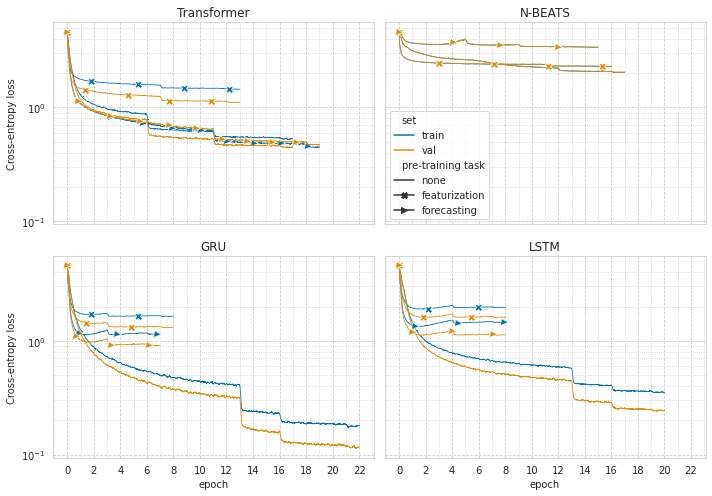

In [19]:
fig, axes = pre_task_loss_plots_per_model(df_ff, hue='set', hue_order=['train', 'val'], task='classification', xticks_every=2, markersize=7, markevery=0.2)
fig.savefig('../../Resources/Thesis/feature-freeze-classification-loss.pdf', format='pdf');

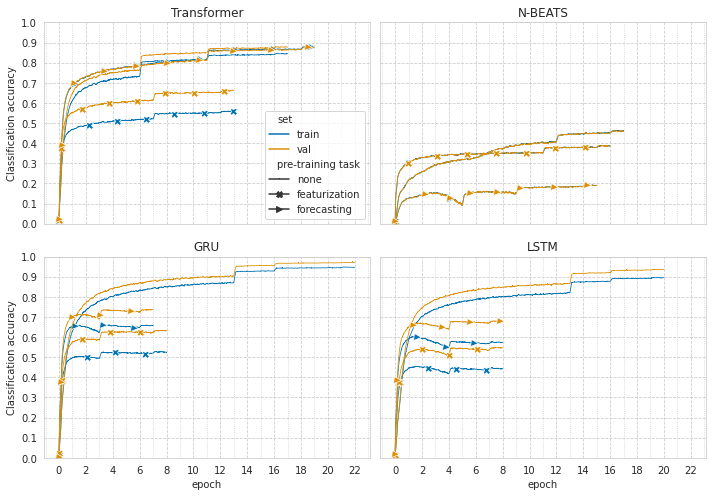

In [22]:
fig, axes = accuracy_plots_per_model(
    data=df_ff,
    hue='set', 
    hue_order=['train', 'val'],
    style='pre-training task',
    style_order=list(filter(lambda s: s != 'classification', tasks)),
    xticks_every=2,
    legend_pos=0,
    markersize=7,
    markevery=0.2,
    yticks_every=0.1,
    ncol=1,
)
fig.savefig('../../Resources/Thesis/feature-freeze-classification-accuracy.pdf', format='pdf');

## Random sampling

In [16]:
rs = pd.read_pickle('../../Resources/random-sampling.pkl')

In [117]:
for t, group in rs[rs.model == 'N-BEATS'].groupby(['set']):
    df = group[group.metric == 'loss.cross']
    first = df[df.seed == '2'].value.values
    second = df[df.seed == '4'].value.values
    m = min(len(first), len(second))
    print(t, np.mean(first[:m] - second[:m]))

test 0.0
train 0.0
val 0.0


In [70]:
rs_rolled = rolling(rs, window=500, skip=20)

  0%|          | 0/240 [00:00<?, ?it/s]

In [104]:
p_rs = {
    'style': 'set',
    'style_order': ['train', 'val'],
    'dashes': [(2, 2), (4, 0)],
    'markers': True,
    'hue': 'seed',
    'hue_order': ['2', '3', '4'],#list(map(lambda i: str(i), range(5))),
    'xticks_every': 5,
    'xticks_minor': 5,
    'markersize': 6,
    'markevery': (0.2, 0.2),# , (0.1, 0.3),
    'fig_size': (12, 8),
    'sharex': False,
    'sharey': False,
    'ncol': 1,
}

AttributeError: 'Line2D' object has no property 'xlim'

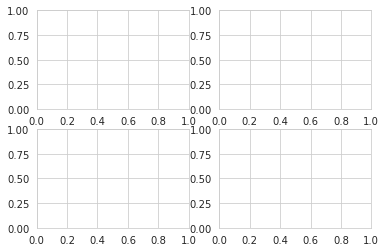

In [105]:
fig, axes = cross_loss_plots_per_model(data=rs_rolled, **p_rs)
fig.tight_layout()
fig.savefig('../../Resources/Thesis/random-sampling-classification-loss.pdf', format='pdf');

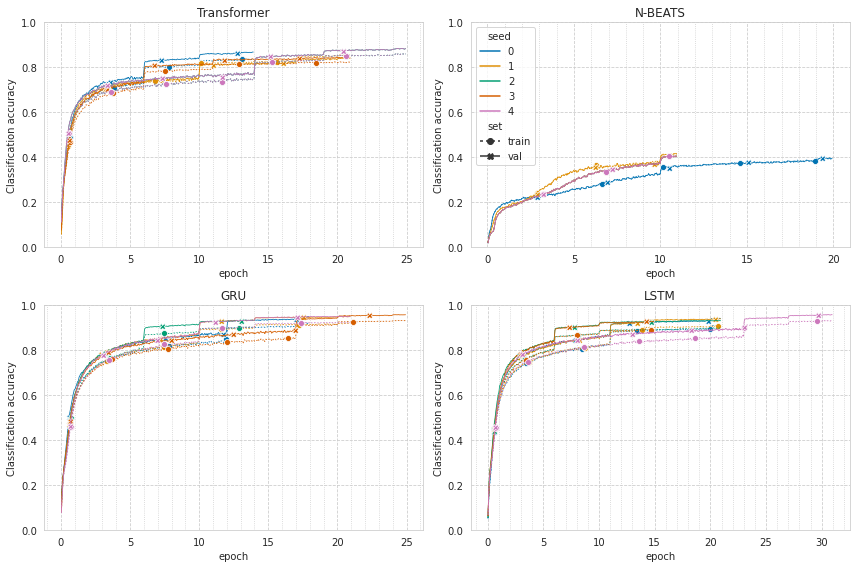

In [92]:
fig, axes = accuracy_plots_per_model(data=df_rs_rolled, **p_rs,)
fig.savefig('../../Resources/Thesis/random-sampling-classification-accuracy.pdf', format='pdf');

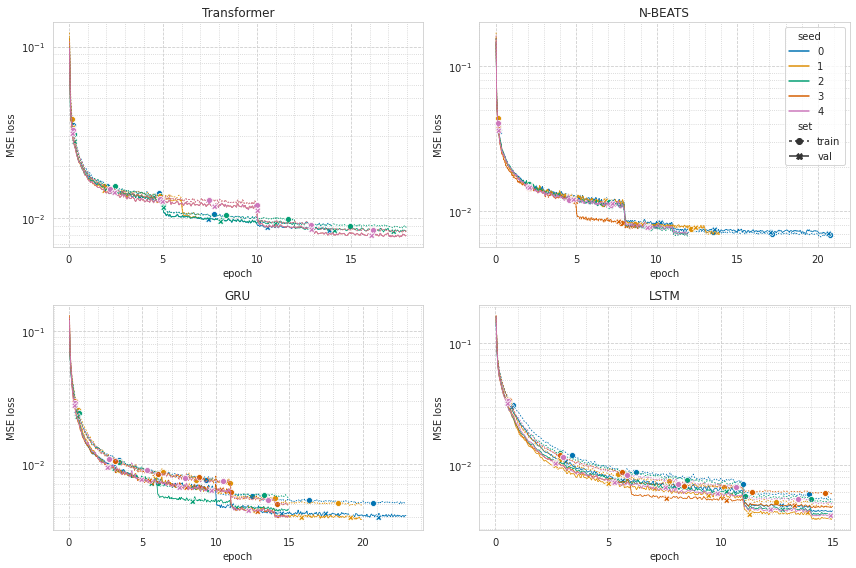

In [93]:
fig, axes = mse_loss_plots_per_model(data=df_rs_rolled, **p_rs,)
fig.savefig('../../Resources/Thesis/random-sampling-forecasting-loss.pdf', format='pdf');

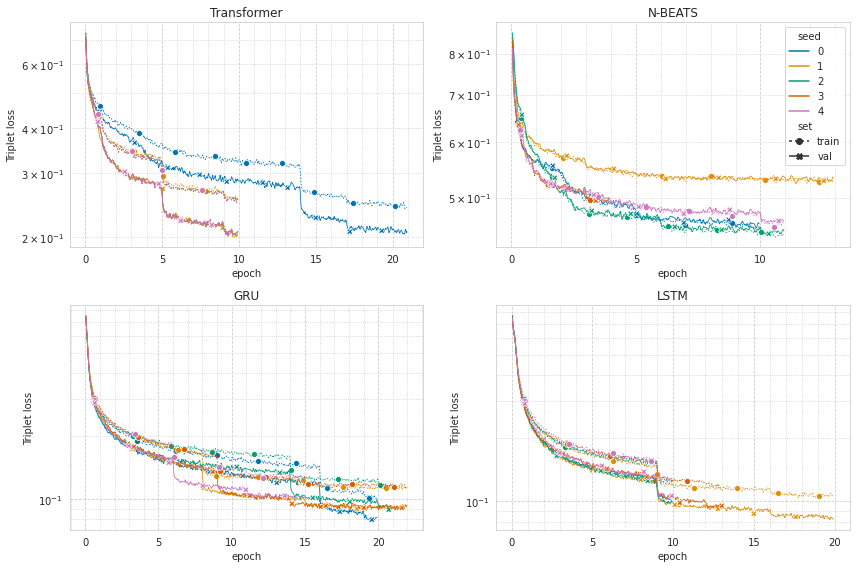

In [94]:
fig, axes = triplet_loss_plots_per_model(data=df_rs_rolled, **p_rs,)
fig.savefig('../../Resources/Thesis/random-sampling-featurization-loss.pdf', format='pdf');

## Prober

In [54]:
df_pr = pd.read_pickle('../../Resources/prober.pkl')

In [ ]:
df_pr

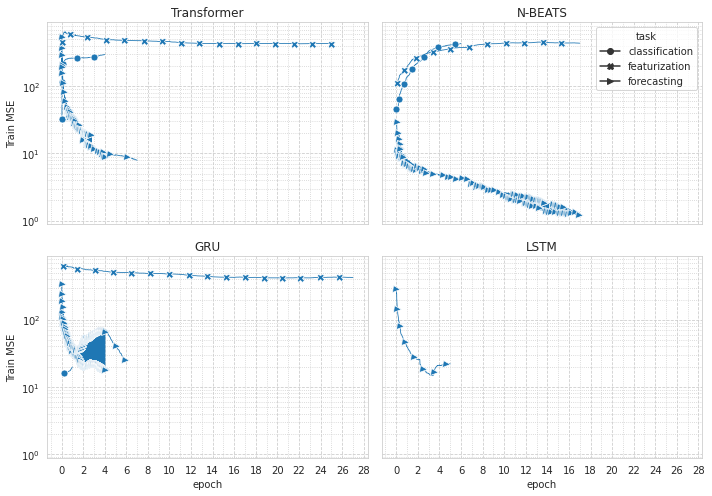

In [18]:
plots_per_model(
    data=df_pr,
    y='loss.mse.train',
    style='task',
    ylogscale=True,
    ylabel='Train MSE',
    sharex=True,
    sharey=True,
    xticks_every=2,
    markersize=7,
    markevery=0.05,
    ncol=1,
);

## Few Shot (Sprott)

In [53]:
df_fs = pd.read_pickle('../../Resources/few-shot.pkl')

In [ ]:
p_fs = {
    'x': 'epoch',
    'hue': 'attractors',
    'style': 'pre-training',
    'sharex': True,
    'sharey': True,
    'xticks_every': 0.2,
    'markers': True,
    'markersize': 7,
}

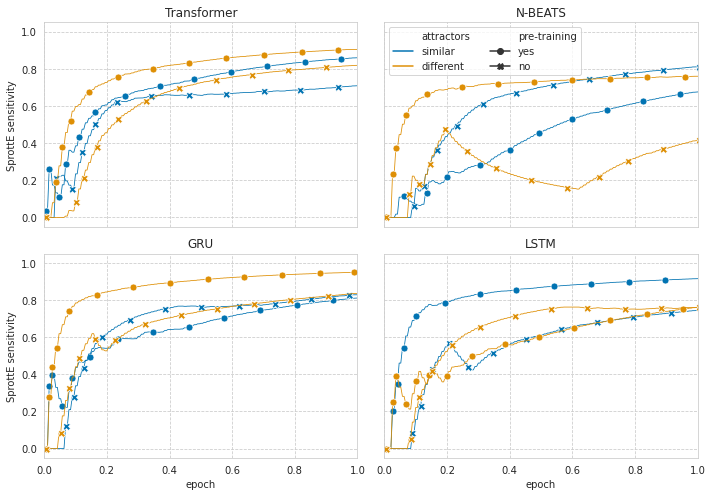

In [7]:
fig, axes = plots_per_model(
    data=df_fs[df_fs.metric == 'SprottE.sensitivity'], y='value', ylabel='SprottE sensitivity', ylogscale=False, **p_fs
)
axes[0, 0].set_xlim(0, 1)
fig.savefig('../../Resources/Thesis/sprott-sensitivity.pdf', format='pdf');

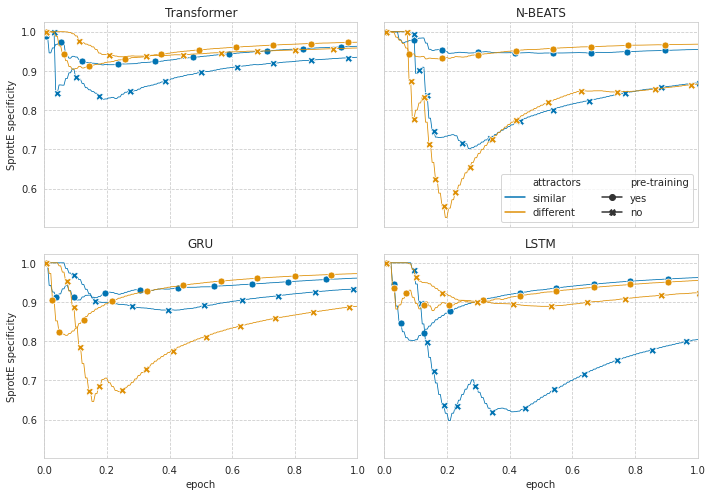

In [8]:
fig, axes = plots_per_model(
    data=df_fs[df_fs.metric == 'SprottE.specificity'], y='value', ylabel='SprottE specificity', ylogscale=False, **p_fs
)
axes[0, 0].set_xlim(0, 1)
fig.savefig('../../Resources/Thesis/sprott-specificity.pdf', format='pdf');

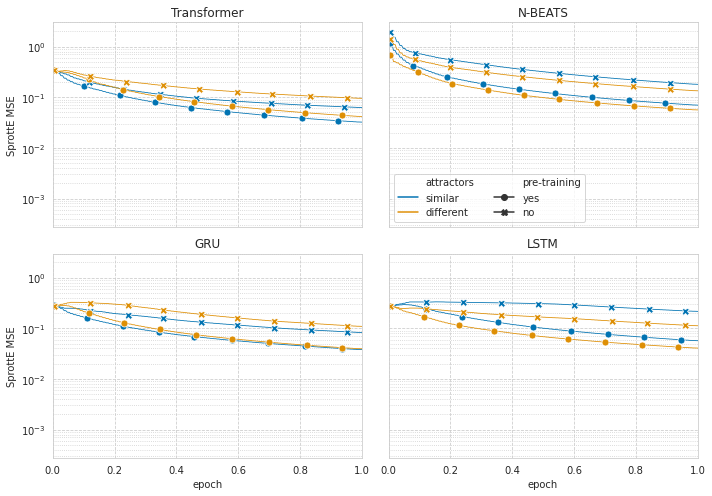

In [9]:
fig, axes = plots_per_model(
    data=df_fs[df_fs.metric == 'SprottE.loss.mse'], y='value', ylabel='SprottE MSE', ylogscale=True, **p_fs
)
axes[0, 0].set_xlim(0, 1)
fig.savefig('../../Resources/Thesis/sprott-mse.pdf', format='pdf');

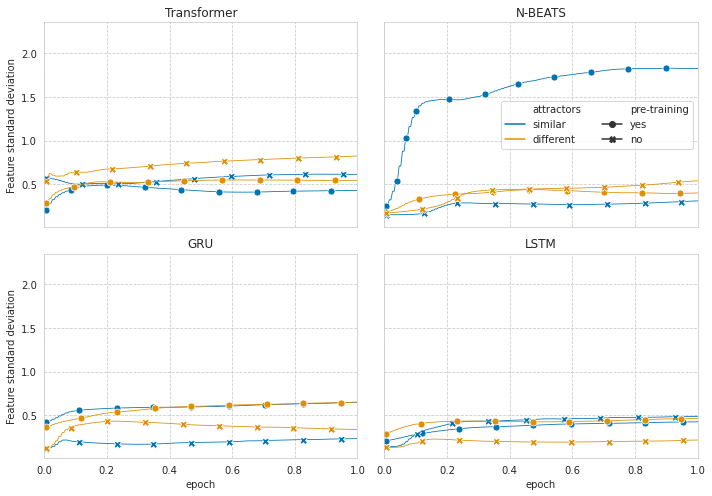

In [10]:
fig, axes = plots_per_model(
    data=df_fs[df_fs.metric == 'SprottE.feature.std'], y='value', ylabel='Feature standard deviation', ylogscale=False, **p_fs
)
axes[0, 0].set_xlim(0, 1)
fig.savefig('../../Resources/Thesis/sprott-feature-std.pdf', format='pdf');